In [25]:
import numpy as np
import json
import os
import gc
from collections import defaultdict
from gensim.models.keyedvectors import KeyedVectors
from gensim.models import TfidfModel
from gensim import corpora,similarities,matutils
from gensim.parsing.preprocessing import remove_stopwords
from nltk.tokenize import word_tokenize

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K

import pickle

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:

docs = [(doc["id"],(doc["title"]+doc["body"])) for doc in json.load(open("crag_doc.json","r"))]
queries = [(query["query number"],query["query"]) for query in json.load(open("crag_queries.json","r"))][:-1]
relevance = json.load(open("crag_relevance.json","r"))


STOP_WORDS = True

if STOP_WORDS:
    docs = { k:word_tokenize(remove_stopwords(v)) for k,v in docs}
    queries = { k:word_tokenize(remove_stopwords(v)) for k,v in queries}
else:
    docs = { k:word_tokenize(v) for k,v in docs}
    queries = { k:word_tokenize(v) for k,v in queries}

query_relevance = defaultdict(list)
[query_relevance[line["query_num"]].append((line["id"],line["position"])) for line in relevance]
query_relevance = [(k,list(map(lambda t:int(t[0]),sorted(v, key=lambda x:-x[1])))) for k,v in query_relevance.items()]
query_relevance = { int(k):v for k,v in query_relevance}

#remove stop words
#docs = { k:remove_stopwords(v) for k,v in docs}
#queries = { k:remove_stopwords(v) for k,v in queries}

print("Num documents",len(docs),"Num queries",len(queries))


Num documents 1400 Num queries 225


In [27]:
def sequences_to_texts(texts):
    return [' '.join([reverse_word_index.get(i, '?') for i in text]) for text in texts]

## Load Keras tokanizer
with open(os.path.join("..","models","tokenizer.pickle"), 'rb') as handle:
    keras_tokenizer = pickle.load(handle)

## Tokenize and padding the data

In [28]:
MAX_DOC_LENGTH = 150
MAX_QUERY_LENGTH = 20 

#TODO tokenize and padding the data
docs_tokenized_padded = {k:(pad_sequences(keras_tokenizer.texts_to_sequences([v]),value=keras_tokenizer.word_index["<PAD>"],padding='pre',maxlen=MAX_DOC_LENGTH)[0]) for k,v in docs.items()}
queries_tokenized_padded = {k:(pad_sequences(keras_tokenizer.texts_to_sequences([v]),value=keras_tokenizer.word_index["<PAD>"],padding='pre',maxlen=MAX_QUERY_LENGTH)[0]) for k,v in queries.items()}


## Load pre trained similarity model

In [30]:
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Activation
def custom_activation(x):
    return K.sigmoid(x*10-3)

get_custom_objects().update({'custom_activation': Activation(custom_activation)})

similarity_model = load_model(os.path.join("..","models","similarity_model_no_dropout.hdf5"))
#similarity_model = load_model(os.path.join("..","models","best_similarity_model_generator_allpos_400_no_dropout_adam"))
#best_similarity_model_generator_allpos_50NEG_200_no_dropout_adam
similarity_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
document_words_input (InputLaye (None, 150)          0                                            
__________________________________________________________________________________________________
query_words_input (InputLayer)  (None, 20)           0                                            
__________________________________________________________________________________________________
doc_projection_model (Model)    (None, 100)          1489900     document_words_input[0][0]       
__________________________________________________________________________________________________
query_projection_model (Model)  (None, 100)          1489900     query_words_input[0][0]          
__________________________________________________________________________________________________
dot (Dot) 

## Get Document and Query Projections models

In [31]:
doc_model = similarity_model.get_layer("doc_projection_model")
query_model = similarity_model.get_layer("query_projection_model")

## Apply the projection to the documments and queries

In [38]:
BATCH_SIZE = 500

list_keys = list(docs_tokenized_padded.keys())
list_docs = list(docs_tokenized_padded.values())

docs_projected = {}

for i in range(0,len(list_keys),BATCH_SIZE):
    projection = doc_model.predict_on_batch(np.array(list_docs[i:i+BATCH_SIZE]))
    norm = np.linalg.norm(projection,axis=1)
    norm = norm.reshape((norm.shape[0],1))
    projection = projection/norm
    for j,k in enumerate(list_keys[i:i+BATCH_SIZE]):
        docs_projected[k] = projection[j]

doc_emb_matrix = np.vstack(list(docs_projected.values()))
doc_emb_norm_matrix = np.linalg.norm(doc_emb_matrix, axis=1) #pre compute l2-norm

        
BATCH_SIZE = 100
list_q_keys = list(queries_tokenized_padded.keys())
list_queries = list(queries_tokenized_padded.values())

queries_projected = {}

for i in range(0,len(list_q_keys),BATCH_SIZE):
    projection = query_model.predict_on_batch(np.array(list_queries[i:i+BATCH_SIZE]))
    norm = np.linalg.norm(projection,axis=1)
    norm = norm.reshape((norm.shape[0],1))
    projection = projection/norm
    for j,k in enumerate(list_q_keys[i:i+BATCH_SIZE]):
        queries_projected[k] = projection[j]


In [39]:
def _sim_cos_vec(embedding_matrix,norm_matrix,word_vec):
    
    dot_product = np.dot(embedding_matrix ,word_vec)

    norm_word = np.linalg.norm(word_vec)

    norm = norm_matrix * norm_word

    return dot_product/ norm

def get_doc_id(docs_emb,results):
    return [ (docs_emb[k][0],v) for k,v in results]

def get_top_k_similars(similaraty_function, docs_concat_emb , queries_avg_emb, query_relevance, top_k=50):
    
    list_recall = []
    list_precision = []
    for query_id,query_vec in queries_avg_emb:

        sims = sorted(enumerate(similaraty_function(query_vec)), key=lambda item: -item[1])

        docs_top_k_id = [k for k,v in get_doc_id(docs_concat_emb,sims[:top_k])]
        docs_relevant = set(query_relevance[query_id])
        
        #not needed for recall
        order_intersect = [ doc for doc in docs_top_k_id if doc in docs_relevant]
        
        list_recall.append(len(order_intersect)/len(query_relevance[query_id]))
        list_precision.append(len(order_intersect)/top_k)
        
    return list_recall,list_precision

In [40]:
TOP_K=50

recall,precision = get_top_k_similars(lambda q:_sim_cos_vec(doc_emb_matrix,doc_emb_norm_matrix,q),list(docs_projected.items()),list(queries_projected.items()),query_relevance,top_k=TOP_K)

print("Using my implementation of cos sim, RECALL",sum(recall)/len(recall),"PRECISION",sum(precision)/len(precision))


Using my implementation of cos sim, RECALL 0.0019363969363969363 PRECISION 0.00035555555555555557


In [41]:
#Visualize FOR query 1
query_id = 150

#relevants document to query 1 IN SPACE
rel_doc_emb =[ doc_emb for k,doc_emb in docs_projected.items() if k in set(query_relevance[query_id])]
query_pca = PCA(n_components=2)
query_pca.fit_transform(list(queries_projected.values()))

pca = PCA(n_components=2)
pca_emb = pca.fit_transform(list(docs_projected.values()))
pca_emb_doc_rel = pca.transform(rel_doc_emb)
pca_emb_query = pca.transform([queries_projected[query_id]])
print(pca.explained_variance_ratio_)

[0.3013732  0.19980899]


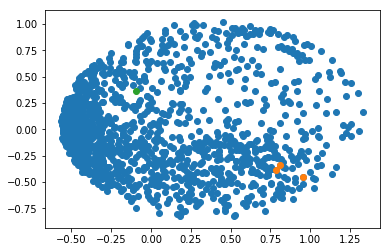

In [42]:
all_x, all_y = zip(*pca_emb)
doc_x, doc_y = zip(*pca_emb_doc_rel)
query_x,query_y = zip(*pca_emb_query)
plt.scatter(all_x,all_y)
plt.scatter(doc_x,doc_y)
plt.scatter(query_x,query_y)

In [43]:
def sigmoid(x, derivative=False):
    sigm = 1. / (1. + np.exp(-x))
    if derivative:
        return sigm * (1. - sigm)
    return sigm

In [44]:
print(similarity_model.layers)
similarity_model.layers[-1].get_weights()
#sorted(enumerate(_sim_cos_vec(doc_emb_matrix,doc_emb_norm_matrix,queries_projected[query_id])), key=lambda item: -item[1])

[<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f2f6d747f98>, <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f2f6d747e48>, <tensorflow.python.keras.engine.training.Model object at 0x7f2f6d747ba8>, <tensorflow.python.keras.engine.training.Model object at 0x7f2f6d41f3c8>, <tensorflow.python.keras.layers.merge.Dot object at 0x7f2f6d083780>, <tensorflow.python.keras.layers.core.Dense object at 0x7f2f6d0460b8>]


[array([[-3.2083561]], dtype=float32), array([-1.028317], dtype=float32)]

In [45]:
r = _sim_cos_vec(doc_emb_matrix,doc_emb_norm_matrix,queries_projected[query_id])

In [46]:
recall,precision = get_top_k_similars(lambda q:sigmoid(_sim_cos_vec(doc_emb_matrix,doc_emb_norm_matrix,q)*-3.208-1.0283),list(docs_projected.items()),list(queries_projected.items()),query_relevance,top_k=TOP_K)

print("Using my implementation of cos sim, RECALL",sum(recall)/len(recall),"PRECISION",sum(precision)/len(precision))

Using my implementation of cos sim, RECALL 0.6225441635035496 PRECISION 0.0924444444444443


In [51]:
r

array([0.14746037, 0.18062676, 0.1798767 , ..., 0.17580585, 0.17775922,
       0.19016822], dtype=float32)